In [89]:
import pandas as pd
import numpy as np
import missingno

# plotting
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# sklearn
# from sklearn.pipeline import make_pipeline
import sklearn.metrics as metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import RandomizedSearchCV

# catboost
from catboost import CatBoostClassifier
from catboost import Pool

# imblearn
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE

sns.set()

SEED = 2

pd.set_option('display.max_columns', 500)

In [90]:
df = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [91]:
target = 'rain_tomorrow'

In [92]:
df.head()

,id,date,location,min_temp,max_temp,rainfall,evaporation,sunshine,wind_gust_dir,wind_gust_speed,wind_dir9am,wind_dir3pm,wind_speed9am,wind_speed3pm,humidity9am,humidity3pm,pressure9am,pressure3pm,cloud9am,cloud3pm,temp9am,temp3pm,rain_today,rain_tomorrow
0,6364,2010-11-11,BadgerysCreek,16.2,28.9,11.4,NaN,NaN,SW,37.0,N,NNE,7.0,15.0,78.0,52.0,1017.2,1011.7,NaN,NaN,20.3,27.9,1.0,0
1,7985,2011-03-09,Sale,14.6,28.3,0.0,NaN,NaN,SSE,35.0,WNW,SSE,11.0,30.0,81.0,65.0,1012.9,1010.4,7.0,7.0,19.0,24.4,0.0,1
2,5021,2014-06-06,Nhil,2.6,16.3,0.0,NaN,NaN,S,31.0,S,SSW,7.0,20.0,93.0,61.0,1033.1,1031.0,NaN,NaN,5.9,14.6,0.0,0
3,28546,2017-06-07,Townsville,14.0,25.9,0.0,NaN,NaN,WNW,35.0,SSW,NE,7.0,24.0,66.0,37.0,1020.4,1016.9,NaN,NaN,20.9,24.7,0.0,0
4,42222,2016-12-13,Uluru,16.7,41.7,0.0,NaN,NaN,SW,61.0,NNE,WSW,26.0,15.0,17.0,7.0,1006.1,1002.6,NaN,NaN,33.2,41.1,0.0,0


In [93]:
# look at target breakdown, this sets baseline
# pretty imbalanced
df[target].value_counts(normalize=True)

0    0.775613
1    0.224387
Name: rain_tomorrow, dtype: float64

In [94]:
# look at the dataset
# focus on nulls
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34191 entries, 0 to 34190
Data columns (total 24 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               34191 non-null  int64  
 1   date             34191 non-null  object 
 2   location         34191 non-null  object 
 3   min_temp         34034 non-null  float64
 4   max_temp         34121 non-null  float64
 5   rainfall         33834 non-null  float64
 6   evaporation      416 non-null    object 
 7   sunshine         625 non-null    object 
 8   wind_gust_dir    31906 non-null  object 
 9   wind_gust_speed  31920 non-null  float64
 10  wind_dir9am      31759 non-null  object 
 11  wind_dir3pm      33250 non-null  object 
 12  wind_speed9am    33863 non-null  float64
 13  wind_speed3pm    33541 non-null  float64
 14  humidity9am      33738 non-null  float64
 15  humidity3pm      33294 non-null  float64
 16  pressure9am      30810 non-null  float64
 17  pressure3pm 

In [95]:
px.histogram(df, x='location', color=target)

In [96]:
px.histogram(df, x='wind_gust_dir', color=target)

<AxesSubplot:>

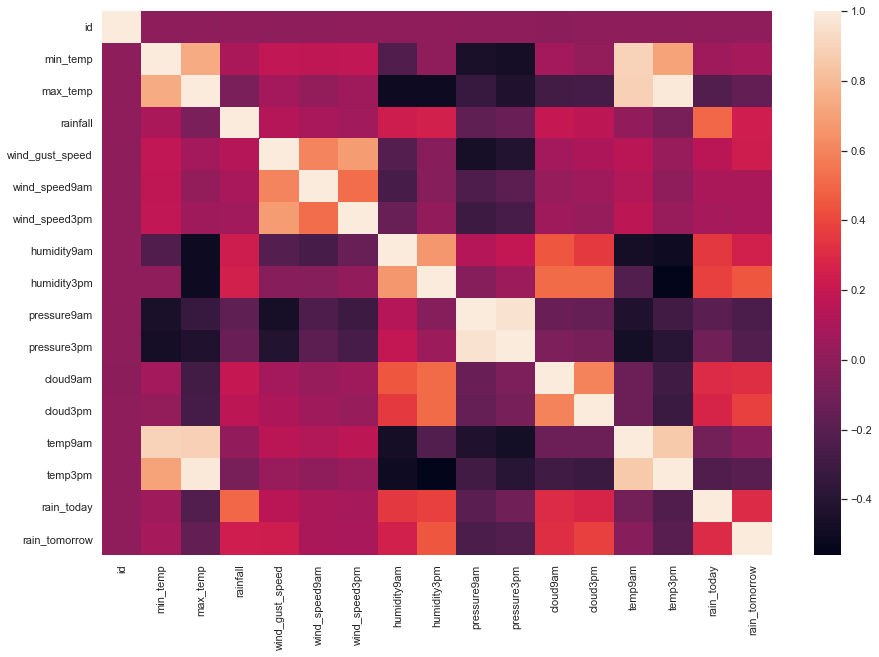

In [97]:
fig, ax = plt.subplots(figsize=[15,10])
sns.heatmap(df.corr())

<AxesSubplot:>

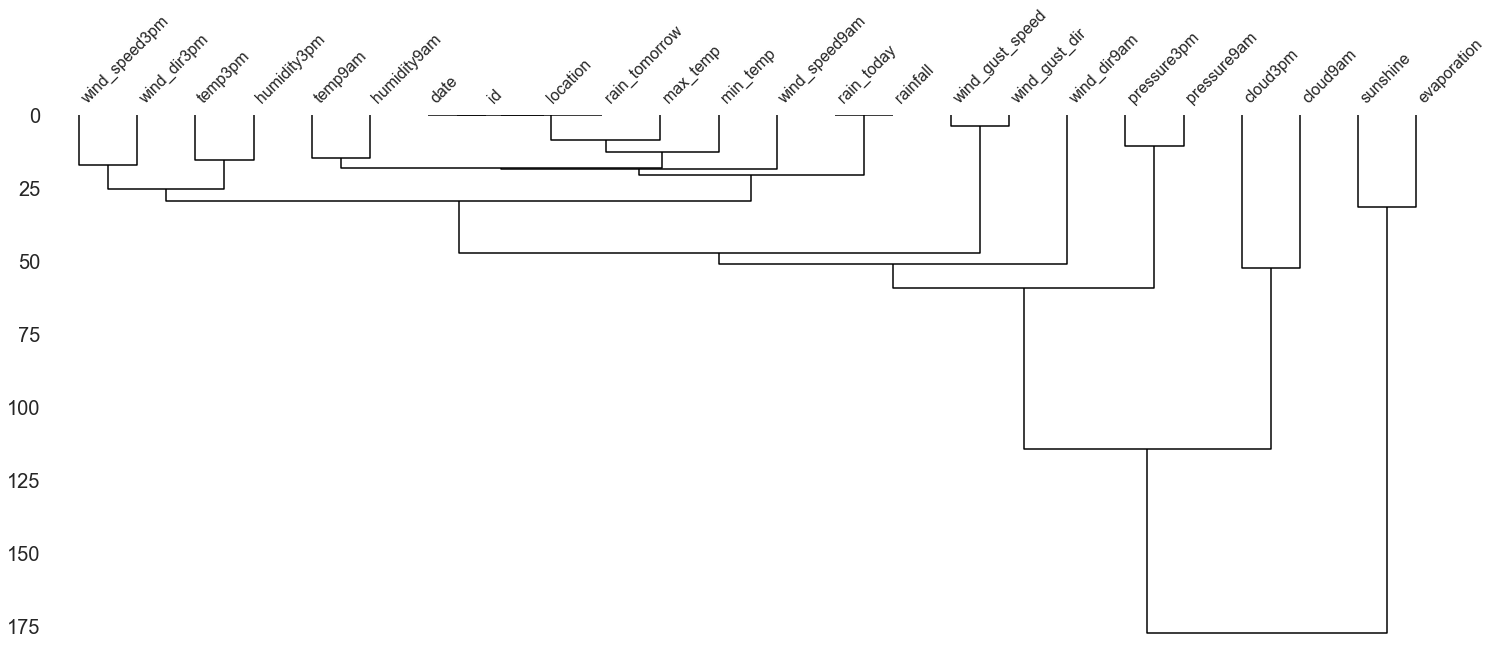

In [98]:
missingno.dendrogram(df)

<AxesSubplot:>

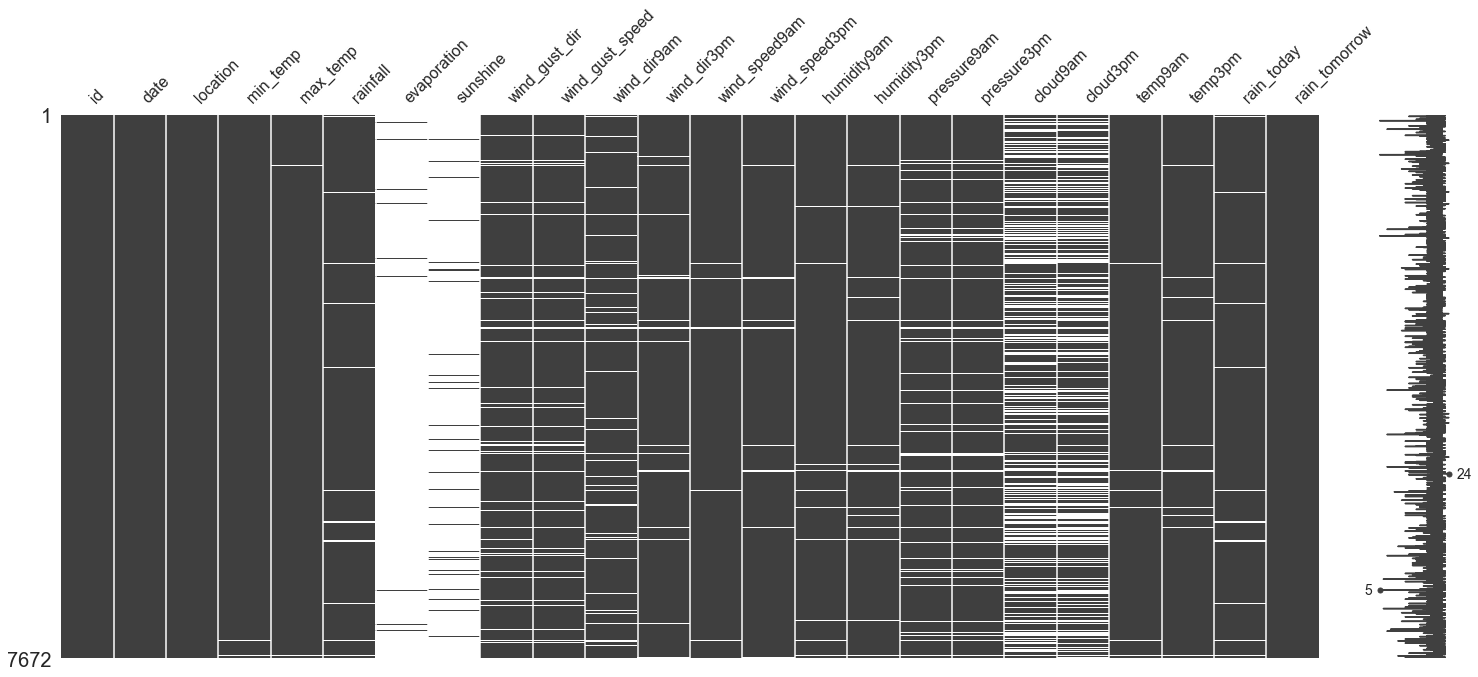

In [99]:
missingno.matrix(df.query('rain_tomorrow == 1'))

# way more info for make and model of aircraft when there's damage
# probably because they need it

<AxesSubplot:>

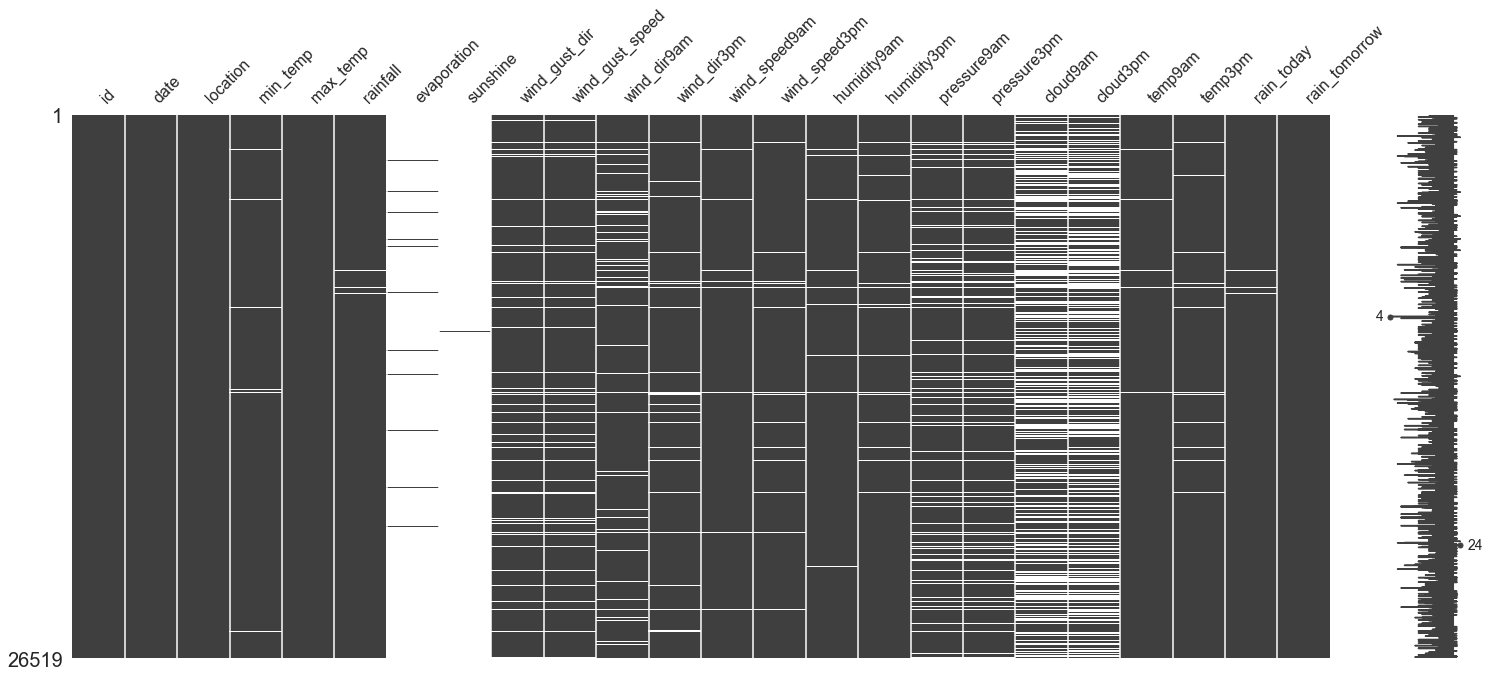

In [100]:
missingno.matrix(df.query('rain_tomorrow == 0'))

<AxesSubplot:>

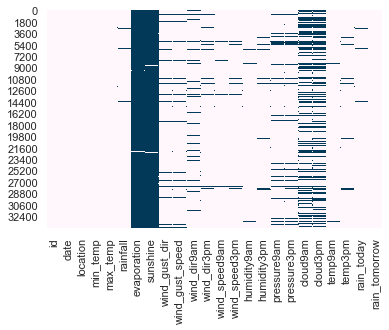

In [101]:
# missing data
# let's look at them more closely: evaporation & sunshine have a ton missing
# code modified from https://www.kaggle.com/chandrimad31/rainfall-prediction-using-7-popular-models
sns.heatmap(df.isnull(), cbar=False, cmap='PuBu')

In [102]:
def clean_train(df):
    df = (df.pipe(string_to_datetime, 'date')
            .pipe(data_types)
            .pipe(drop_cols)
            .pipe(impute)
            .pipe(label_encoder)
            .pipe(mice_impute)
         )
    
    return df

def clean_test(df):
    
    "the only difference is that data_types & mice_impute_test do not have the target"
    
    df = (df.pipe(string_to_datetime, 'date')
            .pipe(data_types_test)
            .pipe(drop_cols)
            .pipe(impute)
            .pipe(label_encoder)
            .pipe(mice_impute_test)
         )
    
    return df


def drop_cols(df):
    # these two cols have very high missing data
    cols = ['evaporation', 'sunshine']
    df = df.drop(columns=cols)
    
    return df


# there's time series data
def string_to_datetime(df, var):
    """
    Converts string representation of date into datetime.
    Splits datetime into separate columns.
    
    Only going to use this on filename for easier indexing.
    """
    df = df.copy()
    
    df['time'] = pd.to_datetime(df[var])
   
    df['day'] = df['time'].dt.day
    df['month'] = df['time'].dt.month
    df['year'] = df['time'].dt.year
    
    df = df.drop(columns=['time', var])

    return df

def data_types(df):
    # change dtypes from object to numeric
    cols = ['min_temp', 'max_temp', 'rainfall', 'wind_gust_speed', 
            'wind_speed9am', 'wind_speed3pm', 'humidity9am',
            'humidity3pm', 'pressure9am', 'pressure3pm', 'cloud9am', 
            'cloud3pm','temp9am', 'temp3pm', 'rain_today', 'rain_tomorrow']
    
    df[cols] = df[cols].apply(pd.to_numeric)
  
    return df

def data_types_test(df):
    # change dtypes from object to numeric
    cols = ['min_temp', 'max_temp', 'rainfall', 'wind_gust_speed', 
            'wind_speed9am', 'wind_speed3pm', 'humidity9am',
            'humidity3pm', 'pressure9am', 'pressure3pm', 'cloud9am', 
            'cloud3pm','temp9am', 'temp3pm', 'rain_today']
    
    df[cols] = df[cols].apply(pd.to_numeric)
  
    return df


def impute(df):
    """
    impute categorial variables with mode
    """
    # look at cat vars to include
    cat_vars = df.select_dtypes(include=['object']).columns.tolist()
    
    for var in cat_vars:
        df[var] = df[var].fillna(df[var].mode()[0])
        
    return df


def label_encoder(df):
    #### Label Encoder
    
    # I'm pretty sure the label encoder is unnecessary here bc of catboost handling categoricals automatically
    # but using it to help inpute missing data
    
    # converts categorical data into numbers
    # convert the same category to a number with the same value
    # labels are ordered randomly (in the existing order of the data)
    # becomes ordinal (which might not be good)
    # code from: https://www.kaggle.com/chandrimad31/rainfall-prediction-using-7-popular-models

    # look at cat vars to include
    # print(df.select_dtypes(include=['object']).columns.tolist())

    # LabelEncoder() accepts an array
    # to encode in a column:
    # 1. label_enc = LabelEncoder()
    # 2. df[col] = label_enc.fit_transform(df[col])

    lencoders = {}
    for col in df.select_dtypes(include=['object']).columns:
        # initialize class with key-value pair in dict
        lencoders[col] = LabelEncoder()
        # fit_transform
        df[col] = lencoders[col].fit_transform(df[col])

    return df

def mice_impute(df):
    
    # MICE: Multiple Imputation by Chained Equations
    # code: https://www.kaggle.com/chandrimad31/rainfall-prediction-using-7-popular-models
    # what is MICE? https://stats.stackexchange.com/questions/421545/multiple-imputation-by-chained-equations-mice-explained
    # scikit-learn: A strategy for imputing missing values by modeling each feature with missing values 
    # as a function of other features in a round-robin fashion.

    df = df.copy(deep=True) 
    mice_imputer = IterativeImputer()
    df.iloc[:, :] = mice_imputer.fit_transform(df)

    # this converts all values to floats. catboost cannot handle floats for categorical vars
    # convert the cat variables to int
    # add the feature engineered datetime variables
    cat_features = ['location', 'wind_gust_dir', 'wind_dir9am', 'wind_dir3pm', 
                    'rain_today', 'rain_tomorrow', 'day', 'month', 'year']

    df[cat_features] = df[cat_features].astype(int)
    
    return df

def mice_impute_test(df):
    
    # MICE: Multiple Imputation by Chained Equations
    # code: https://www.kaggle.com/chandrimad31/rainfall-prediction-using-7-popular-models
    # what is MICE? https://stats.stackexchange.com/questions/421545/multiple-imputation-by-chained-equations-mice-explained
    # scikit-learn: A strategy for imputing missing values by modeling each feature with missing values 
    # as a function of other features in a round-robin fashion.

    df = df.copy(deep=True) 
    mice_imputer = IterativeImputer()
    df.iloc[:, :] = mice_imputer.fit_transform(df)

    # this converts all values to floats. catboost cannot handle floats for categorical vars
    # convert the cat variables to int
    # add the feature engineered datetime variables
    cat_features = ['location', 'wind_gust_dir', 'wind_dir9am', 'wind_dir3pm', 
                    'rain_today', 'day', 'month', 'year']

    df[cat_features] = df[cat_features].astype(int)
    
    return df

In [103]:
# let's just look at years
df = clean_train(df)

In [104]:
# Table of features with missing data 
# code modified from https://www.kaggle.com/chandrimad31/rainfall-prediction-using-7-popular-models
# most are < 50% missing
# drop evaporation & sunshine
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing = pd.concat([total, percent], axis=1, keys=['Total', 'Percent Missing'])
missing.head(5)

,Total,Percent Missing
id,0,0.0
location,0,0.0
month,0,0.0
day,0,0.0
rain_tomorrow,0,0.0


In [105]:
# double-check for NaNs (there shouldn't be any)
print(df.isna().sum().sum())

0


In [106]:
df.dtypes

id                 float64
location             int64
min_temp           float64
max_temp           float64
rainfall           float64
wind_gust_dir        int64
wind_gust_speed    float64
wind_dir9am          int64
wind_dir3pm          int64
wind_speed9am      float64
wind_speed3pm      float64
humidity9am        float64
humidity3pm        float64
pressure9am        float64
pressure3pm        float64
cloud9am           float64
cloud3pm           float64
temp9am            float64
temp3pm            float64
rain_today           int64
rain_tomorrow        int64
day                  int64
month                int64
year                 int64
dtype: object

In [107]:
# train/val split: val on 2016, 2017
train = df[df['year'] < 2016]
val = df[df['year'] > 2015]

train.shape, val.shape

((28000, 24), (6191, 24))

In [108]:
# Arrange data into X features matrix and y target vector 
X_train = train.drop(columns=target)
y_train = train[target]
X_val = val.drop(columns=target)
y_val = val[target]

# keep entire df
X = df.drop(columns=target)
y = df[target]

In [109]:
### Build Model

In [110]:
#### get list for cat_features
# X_train.columns drops 'rain_tomorrow'
cat_features_names = ['location', 'wind_gust_dir', 'wind_dir9am', 'wind_dir3pm', 
                      'rain_today', 'day', 'month', 'year']
# we need a list of the cols
cat_features = [X_train.columns.get_loc(col) for col in cat_features_names]
cat_features

[1, 5, 7, 8, 19, 20, 21, 22]

In [111]:
# cv modified from https://github.com/catboost/tutorials/blob/master/classification/classification_tutorial.ipynb
cb_classifier = CatBoostClassifier(iterations=15,
                           depth=2,
                           learning_rate=1,
                           loss_function='Logloss',
                           verbose=True,
                           cat_features=cat_features,
                           random_seed=SEED
)

pipeline = make_pipeline(SMOTE(random_state=SEED),
                         cb_classifier
)


params = {'catboostclassifier__learning_rate': [0.03, 0.1],
          'catboostclassifier__depth': [4, 6, 10],
          'catboostclassifier__l2_leaf_reg': [1, 3, 5, 7, 9],
}

cb_search=RandomizedSearchCV(
                pipeline,
                params,
                n_iter=10,
                scoring='neg_log_loss',
                n_jobs=-1,
                cv=5, # e.g. default 5-fold cross validation
                random_state=SEED, verbose=5
)

In [112]:
# plot=True lets you see  graphs of different errors during training
cb_search.fit(
    X_train, y_train
)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
0:	learn: 0.6117733	total: 86ms	remaining: 1.2s
1:	learn: 0.5498712	total: 145ms	remaining: 941ms
2:	learn: 0.5056102	total: 198ms	remaining: 794ms
3:	learn: 0.4733113	total: 253ms	remaining: 695ms
4:	learn: 0.4470601	total: 309ms	remaining: 619ms
5:	learn: 0.4232038	total: 370ms	remaining: 555ms
6:	learn: 0.4054088	total: 425ms	remaining: 485ms
7:	learn: 0.3921154	total: 476ms	remaining: 417ms
8:	learn: 0.3792144	total: 536ms	remaining: 357ms
9:	learn: 0.3688496	total: 596ms	remaining: 298ms
10:	learn: 0.3600866	total: 645ms	remaining: 235ms
11:	learn: 0.3523454	total: 691ms	remaining: 173ms
12:	learn: 0.3446389	total: 743ms	remaining: 114ms
13:	learn: 0.3363504	total: 797ms	remaining: 57ms
14:	learn: 0.3294339	total: 845ms	remaining: 0us


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('smote', SMOTE(random_state=2)),
                                             ('catboostclassifier',
                                              <catboost.core.CatBoostClassifier object at 0x7fcc1956da60>)]),
                   n_jobs=-1,
                   param_distributions={'catboostclassifier__depth': [4, 6, 10],
                                        'catboostclassifier__l2_leaf_reg': [1,
                                                                            3,
                                                                            5,
                                                                            7,
                                                                            9],
                                        'catboostclassifier__learning_rate': [0.03,
                                                                              0.1]},
                   random_state=2, scoring

In [113]:
print('Best hyperparameters', cb_search.best_params_)
print('Cross-validation log loss', cb_search.best_score_)

Best hyperparameters {'catboostclassifier__learning_rate': 0.1, 'catboostclassifier__l2_leaf_reg': 1, 'catboostclassifier__depth': 10}
Cross-validation log loss -0.39462217607469985


In [114]:
best_model = cb_search.best_estimator_

In [115]:
best_model.fit(X_train, y_train)
print('Validation Accuracy: ', best_model.score(X_val, y_val))

0:	learn: 0.6117733	total: 60.4ms	remaining: 845ms
1:	learn: 0.5498712	total: 108ms	remaining: 704ms
2:	learn: 0.5056102	total: 157ms	remaining: 627ms
3:	learn: 0.4733113	total: 204ms	remaining: 562ms
4:	learn: 0.4470601	total: 256ms	remaining: 512ms
5:	learn: 0.4232038	total: 315ms	remaining: 472ms
6:	learn: 0.4054088	total: 369ms	remaining: 422ms
7:	learn: 0.3921154	total: 421ms	remaining: 368ms
8:	learn: 0.3792144	total: 471ms	remaining: 314ms
9:	learn: 0.3688496	total: 519ms	remaining: 259ms
10:	learn: 0.3600866	total: 573ms	remaining: 208ms
11:	learn: 0.3523454	total: 619ms	remaining: 155ms
12:	learn: 0.3446389	total: 670ms	remaining: 103ms
13:	learn: 0.3363504	total: 719ms	remaining: 51.4ms
14:	learn: 0.3294339	total: 771ms	remaining: 0us
Validation Accuracy:  0.8237764496850266


In [116]:
# train on entire dataset
best_model.fit(X,
               y, 
)

0:	learn: 0.6135442	total: 64.3ms	remaining: 900ms
1:	learn: 0.5526600	total: 119ms	remaining: 771ms
2:	learn: 0.5096892	total: 170ms	remaining: 681ms
3:	learn: 0.4746600	total: 220ms	remaining: 606ms
4:	learn: 0.4468307	total: 275ms	remaining: 550ms
5:	learn: 0.4270498	total: 329ms	remaining: 493ms
6:	learn: 0.4104075	total: 380ms	remaining: 435ms
7:	learn: 0.3950180	total: 430ms	remaining: 377ms
8:	learn: 0.3837173	total: 481ms	remaining: 320ms
9:	learn: 0.3750687	total: 544ms	remaining: 272ms
10:	learn: 0.3643461	total: 600ms	remaining: 218ms
11:	learn: 0.3529917	total: 648ms	remaining: 162ms
12:	learn: 0.3461232	total: 701ms	remaining: 108ms
13:	learn: 0.3388527	total: 755ms	remaining: 53.9ms
14:	learn: 0.3332406	total: 804ms	remaining: 0us


Pipeline(steps=[('smote', SMOTE(random_state=2)),
                ('catboostclassifier',
                 <catboost.core.CatBoostClassifier object at 0x7fcc9729c8b0>)])

In [117]:
print('Best model params:')
print(best_model.get_params())

Best model params:
{'memory': None, 'steps': [('smote', SMOTE(random_state=2)), ('catboostclassifier', <catboost.core.CatBoostClassifier object at 0x7fcc9729c8b0>)], 'verbose': False, 'smote': SMOTE(random_state=2), 'catboostclassifier': <catboost.core.CatBoostClassifier object at 0x7fcc9729c8b0>, 'smote__k_neighbors': 5, 'smote__n_jobs': None, 'smote__random_state': 2, 'smote__sampling_strategy': 'auto', 'catboostclassifier__iterations': 15, 'catboostclassifier__learning_rate': 0.1, 'catboostclassifier__depth': 10, 'catboostclassifier__l2_leaf_reg': 1, 'catboostclassifier__loss_function': 'Logloss', 'catboostclassifier__random_seed': 2, 'catboostclassifier__verbose': True, 'catboostclassifier__cat_features': [1, 5, 7, 8, 19, 20, 21, 22]}


In [118]:
score = best_model.predict_proba(clean_test(test))

In [119]:
def make_submission(score):
    """Takes prediction array and returns a Kaggle submission df"""
    
    # get the predicted probabilities for the positive label only
    pos_score = score[:, 1]
    
    # put into a df with a column label of target
    pos_score = pd.DataFrame(pos_score, columns=[target])
    
    # add original ids from test df 
    submission_df = pd.concat([test.id, pos_score], axis=1)
    
    return submission_df

make_submission(score).to_csv('predictions/catboost_imblearn.csv', index=None)